# 3D Geometries

## Introduction

In this tutorial we will describe how to create 3 dimensional structures that are based on one or more 2d profiles.
We assume that you already know how to create 2d profiles using the `weldx` package.
If this is not the case, please read the corresponding tutorial first.

You will learn:
- about the `Trace` class
- how to define a 3 dimensional geometry using the `Geometry` class
- how to specify geometries with varying cross sections using the `VariableProfile` class

Before we start, run the following code cells to include everything we need.

In [1]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [2]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt


from weldx.transformations import LocalCoordinateSystem
from weldx.geometry import  (Geometry,
                             LinearHorizontalTraceSegment,
                             linear_profile_interpolation_sbs,
                             Profile,
                             RadialHorizontalTraceSegment,
                             Shape,
                             Trace,
                             VariableProfile
                             )


import weldx.transformations as tf
from weldx import Q_

## Trace

The `Trace` class describes an arbitrary path through the 3 dimensional space.
It is build from multiple segments that need to be passed to it when we create the `Trace`.
Currently there are 2 segment types available: the `LinearHorizontalTraceSegment` that represents a straight line and
the `RadialHorizontalTraceSegment` which describes a circular path.
Both segment types have in common that the `z`-value remains constant and that they are free from torsion.

Let's create one instance of each segment type.
All you need to specify when creating a `LinearHorizontalTraceSegment` is its length:

In [3]:
line_segment = LinearHorizontalTraceSegment(length=Q_(10, "cm"))

That's it.
The `RadialHorizontalTraceSegment` needs a little bit more information.
You need to provide its radius, rotation angle and if the rotation is clockwise or counter-clockwise:

In [4]:
arc_segment = RadialHorizontalTraceSegment(radius=Q_(15, "cm"),
                                           angle=Q_(90, "degree"),
                                           clockwise=True)

Now that we have some segments, we can create a `Trace`.
It expects a single segment or a list of segments as first argument.
The individual segments get attached to each other in the same order as they are attached to the list.
Each segment except for the first one gets its start orientation and coordinates from the end of the previous segment.
The initial orientation and coordinates of the `Trace` can be provided in form of a `LocalCoordinateSystem` as optional
second argument during the creation of the class instance.
If you omit the second parameter, the `Trace` starts at the origin and is oriented in positive x-direction.


Here is an example:

In [5]:
trace = Trace([line_segment, arc_segment,line_segment])

We can plot our `Trace` using the `plot` method:

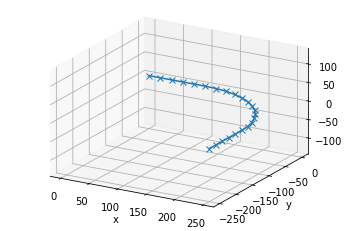

In [6]:
trace.plot(raster_width=Q_(2, "cm"))

Let's provide a initial coordinate system that is rotated by 45 degrees around the y-axis and see how that affects the
result:

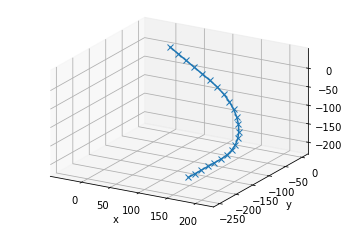

In [7]:
lcs_rot = LocalCoordinateSystem(tf.rotation_matrix_y(Q_(45, "degree")))
trace_rot = Trace([line_segment, arc_segment,line_segment], lcs_rot)
trace_rot.plot(raster_width=Q_(2, "cm"))

Linear and radial trace segments already cover a lot of use cases but they are far from being enough to cover all
possible needs.
If you need more than those two basic segment types, there are two options.
The first one is to implement your own segment type.
This is discussed in detail in another tutorial.
> TODO: Add link to tutorial once it is written

The second option, that you should prefer is the `TODO: SOME_FANCY_NAME_SEGMENT`.
It enables you to describe the course of the trace segment with a mathematical function.
> TODO: Continue once the segment type is implemented

## Describing a 3d geometry

The simplest possible way to describe a 3 dimensional geometry using the `weldx.geometry` package is to create a 2d
`Profile` and extrude it into 3d.
The class that performs this action is called `Geometry`.
It expects a `Profile` that defines the cross section as first argument and a `Trace` that describes
the extrusion path as second one.
Since we already have created a `Trace` all that is missing is a `Profile`.
So let's create one:

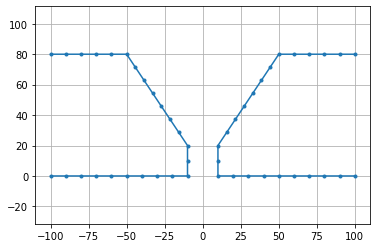

In [8]:
shape_right = Shape().add_line_segments(Q_([[10, 8], [5, 8], [1, 2], [1, 0], [10, 0]], "cm"))
shape_left = shape_right.reflect_across_line([0, 0], [0, 1])
profile = Profile([shape_left, shape_right])
profile.plot(raster_width=Q_(1, "cm"))

Now we can create and plot our `Geometry`:

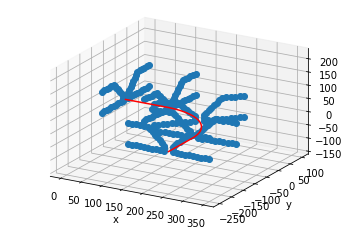

In [9]:
geometry = Geometry(profile=profile, trace=trace)
geometry.plot(profile_raster_width=Q_(1, "cm"),
              trace_raster_width=Q_(10, "cm"))
trace.plot(raster_width=Q_(1, "cm"), axes=plt.gca(), fmt="r-")

## Geometries with varying cross section

The `VariableProfile` class gives us the opportunity to handle 3 dimensional geometries with a varying cross section.
It can be used instead of a `Profile` during the creation of the `Geometry` class.
Three pieces of information are necessary to create a `VariableProfile`.

First a list of profiles is required.
This list represents "snapshots" of known cross sections along the extrusion path.

The second piece of information is a list of numbers that has the same number of elements as the list of profiles.
Each of those numbers defines a coordinate on a 1 dimensional axis for the profile with the same list index.
Their magnitude can be chosen arbitrarily with the exception that the first entry has to be 0 and the list items must be
in ascending order.
Due to the previously mentioned association between the coordinates/numbers and the profiles, the profiles are ordered
by ascending coordinates.
When you pass a `VariableProfile` to a `Geometry`, its first profile is used as the initial profile at the start of
the `Trace` and the last as the one at the end.
This relation enables the `Geometry` class to establish a linear coordinate transformation between the coordinates you
specified in the `VariableProfile` and the corresponding position on the trace.
For example, if you use three profiles with the coordinates `[0, 25, 100]` and your `Trace` has a length of $40 mm$,
then the second profile occurs after $10 mm$ on the `Trace`.

The last thing we need to provide in order to create a `VariableProfile` is how the space between two profiles gets
interpolated.
We pass this information is form of a list that contains the corresponding interpolation functions.
For each pair of profiles we need to specify an interpolation where the first list entry is associated with the first
pair, the second entry with the second pair and so on.
The number of list items is therefore one less than the number of profiles.

Lets have look at an example after this rather long text section. First, we define two more profiles.

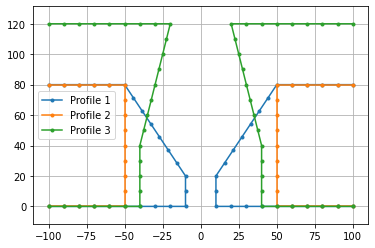

In [10]:
shape_right_2 = Shape().add_line_segments(Q_([[10, 8], [5, 8], [5, 2], [5, 0], [10, 0]], "cm"))
shape_left_2 = shape_right_2.reflect_across_line([0, 0], [0, 1])
profile_2 = Profile([shape_left_2, shape_right_2])

shape_right_3 = Shape().add_line_segments(Q_([[10, 12], [2, 12], [4, 4], [4, 0], [10, 0]], "cm"))
shape_left_3 = shape_right_3.reflect_across_line([0, 0], [0, 1])
profile_3 = Profile([shape_left_3, shape_right_3])


profile.plot(raster_width=Q_(1, "cm"), label="Profile 1")
profile_2.plot(raster_width=Q_(1, "cm"), label="Profile 2", ax=plt.gca())
profile_3.plot(raster_width=Q_(1, "cm"), label="Profile 3", ax=plt.gca())
plt.gca().legend()





Now we create a `VariableProfile`, pass it to a new `Geometry` and plot it:

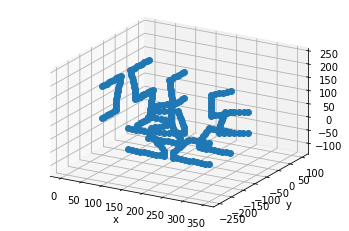

In [11]:
v_profile = VariableProfile([profile_3, profile_2, profile],
                            [0, 40, 100],
                            [linear_profile_interpolation_sbs, linear_profile_interpolation_sbs]
                            )

geometry_vp = Geometry(profile=v_profile,trace=trace)
geometry_vp.plot(profile_raster_width=Q_(1, "cm"),
                 trace_raster_width=Q_(8, "cm"))

## Custom interpolation schemes

You might notice that we used a interpolation function called `linear_profile_interpolation_sbs`.
The "sbs" stands for "segment-by-segment".
It interpolates all of the profile segments linearly in the order as they appear in both involved profiles.
So you need to assure that the segments are ordered accordingly in both profiles.
It also requires that the number of segments is identical and it only works with the `LineSegment`.

You might wonder what alternative functions are provided, but currently there are none.
The reason is that as soon as you start thinking about it, there are so many options that need to be considered that
don't have a unique solution that fits all use cases.
To circumvent this issue, we provide the possibility to use custom interpolation functions.
All that you need to do in order to use your own interpolation scheme is to define a python
function with the following interface:

~~~
def custom_interpolation(Profile, Profile, float) -> Profile
~~~


The `float` parameter is a weighting factor representing the position on the trace segment between both profiles.
The `Geometry` class will pass values between `0` and `1` where `0` is the beginning of the segment and associates with
the first passed `Profile`.
In conclusion, a value of `1` represents the end of the segment and is associated with the second `Profile`.
What you do with this information is up to you.
All that matters is that the function returns a valid `Profile` in the end.

Lets create an example interpolation that returns the first passed profile for weighting factors below `0.4` and the
second one otherwise:

In [12]:
def my_interp(p0, p1, weight):
    if weight < 0.4:
        return p0
    return p1

Now we just create a `VariableProfile` with our new interpolation, combine it with a linear `Trace` inside of a
`Geometry` and plot it:

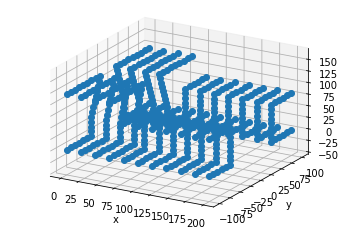

In [13]:
v_profile_custom_interp = VariableProfile([profile_3, profile_2], [0, 1], my_interp)
trace_custom_interp = Trace(LinearHorizontalTraceSegment(Q_(20, "cm")))
geometry_custom_interp = Geometry(v_profile_custom_interp, trace_custom_interp)

geometry_custom_interp.plot(profile_raster_width=Q_(1, "cm"),
                            trace_raster_width=Q_(2, "cm"))